### Frame the problem

Spam is annoying and costs users time. Less spam will improve user experience.

If this were a real spam filter, it would be used to prevent spam from going into a user's inbox. There would likely be a separate folder for spam mail so the user could check for mislabled messages if desired.

Spam filtering is a supervised problem. For the purposes of this project it will be offline.

Performance will be measured by precision and coverage. The dataset contains about 30% spam, 70% ham, and so it would not be appropriate to use accuracy. Precision is more important than recall (when spam is the positive class). 

I'm not sure what is possible yet, so to choose something arbitrary, I'll shoot for 98% precision with 90% coverage.



In [1]:
import chardet
from email import message_from_string
import re
from os import listdir, getcwd
from os.path import isfile, join

import pandas as pd
import numpy as np

from nltk import Text, wordpunct_tokenize
from nltk.stem import LancasterStemmer

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
                                recall_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

### Get the data

In [2]:
spam_dirs = ["spam/spam", "spam/spam_2"]
ham_dirs = ["spam/easy_ham", "spam/easy_ham 2", "spam/hard_ham"]
pwd = getcwd()

def read_directories(directories):
    for d in directories:
        for f in listdir(d):
            if isfile(join(d, f)) and "." in f:
                yield join(d, f)
                
def read_file(path):
    with open(path, 'rb') as f:
        contents = f.read()
    return contents

def read_and_decode(paths):
    raw = []
    for path in paths:
        contents = read_file(path)
        encoding = chardet.detect(contents)["encoding"]
        try:
            decoded = contents.decode(encoding)
        except UnicodeDecodeError:
            print(f"failed to decode spam file {path}")
            continue
        raw.append(decoded)
    return raw
    
    
def load_dataset():
    spam_files = read_directories(join(pwd, d) for d in spam_dirs)
    ham_files = read_directories(join(pwd, d) for d in ham_dirs)
    
    spam_raw = read_and_decode(spam_files)
    ham_raw = read_and_decode(ham_files)
        
    return pd.DataFrame({
        "RawEmails": spam_raw + ham_raw,
        "Class": [1] * len(spam_raw) + [0] * len(ham_raw)
    })
    

original_dataset = load_dataset()

failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0369.2530542de47d461ccb925fcafc6f0ad5
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0304.88cf1d3ce0e138fd9ffb801e675f69b3
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0290.13035c75be0d5b447a10e2263f8c1361
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0100.c60d1c697136b07c947fa180ba3e0441
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0123.68e87f8b736959b1ab5c4b5f2ce7484a
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/00475.3d497c7d96c51986316db566756ff35a
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/01227.04a4f94c7a73b29cb56bf38c7d526116
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/01065.9ecef01b01ca912fa35453196b4dae4c
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/01376.73e738e4cd8121ce3dfb42d190b193c9
failed to decode spam fil

In [3]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   RawEmails  7189 non-null   object
 1   Class      7189 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.5+ KB


In [4]:
original_dataset["Class"].value_counts()

0    5301
1    1888
Name: Class, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    original_dataset["RawEmails"], 
    original_dataset["Class"], 
    shuffle=True,
    stratify=original_dataset["Class"], 
    random_state=42,
)

In [6]:
dataset_spam_ratio = original_dataset["Class"].sum() / len(original_dataset["Class"])
print(f"dataset spam ratio {dataset_spam_ratio}")
print(f"train set spam ratio: {y_train.sum()/ len(y_train)}, test_set spam ratio {y_test.sum() / len(y_test)}")

dataset spam ratio 0.2626234524968702
train set spam ratio: 0.2626599888703395, test_set spam ratio 0.2625139043381535


### Clean and explore the data

In [7]:
# mean length of email grouped by class
X_train.apply(len).to_frame().join(y_train).groupby(by=["Class"]).mean()

,RawEmails
Class,
0,4447.729560
1,6471.815678


In [8]:
def remove_headers(text):
    msg = message_from_string(text)
    payload = msg.get_payload()
    return " ".join(str(m) for m in payload) if isinstance(payload, list) else payload

def remove_html(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    return text
    

def remove_urls(text):
    return re.sub(r"http\S+", "URL", text)

vec_remove_headers = np.vectorize(remove_headers)
vec_remove_html = np.vectorize(remove_html)
vec_remove_urls = np.vectorize(remove_urls)


class RawEmailPreprocessor(BaseEstimator, TransformerMixin):
    """Clean email before feeding into a vectorizer.
    
    It turns out that many of these features result
    in lower performance. Keeping around for 
    posterity/documentation.
    """
    
    def __init__(self, remove_headers=True, remove_html=True, replace_urls=True, lowercase=True):
        self.remove_headers = remove_headers
        self.remove_html = remove_html
        self.replace_urls = replace_urls
        self.lowercase = lowercase
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.remove_headers:
            X = vec_remove_headers(X)
        
        if self.remove_html:
            X = vec_remove_html(X)
        
        if self.replace_urls:
            X = vec_remove_urls(X)
            
        if self.lowercase:
            X = np.char.lower(X)
        
        return X

In [9]:
class StemmedCountVectorizer(CountVectorizer):
    """Stem words after parsing.
    
    This is another example of a cleaning step 
    that resulted in worse performance and is 
    no longer used.
    """
    def __init__(self, stem=True, **kwargs):
        super().__init__(**kwargs)
        self.stem = stem
        self.stemmer = LancasterStemmer()
    
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        if not self.stem:
            return analyzer
        return lambda doc: ([self.stemmer.stem(w) for w in analyzer(doc)])

In [34]:
preparation_pipeline = Pipeline([
    ("clean", RawEmailPreprocessor(lowercase=False, remove_headers=False, replace_urls=False)),
    ("vect", CountVectorizer(max_features=50000, ngram_range=(1, 2))),
    ("tfidf", TfidfTransformer())
])

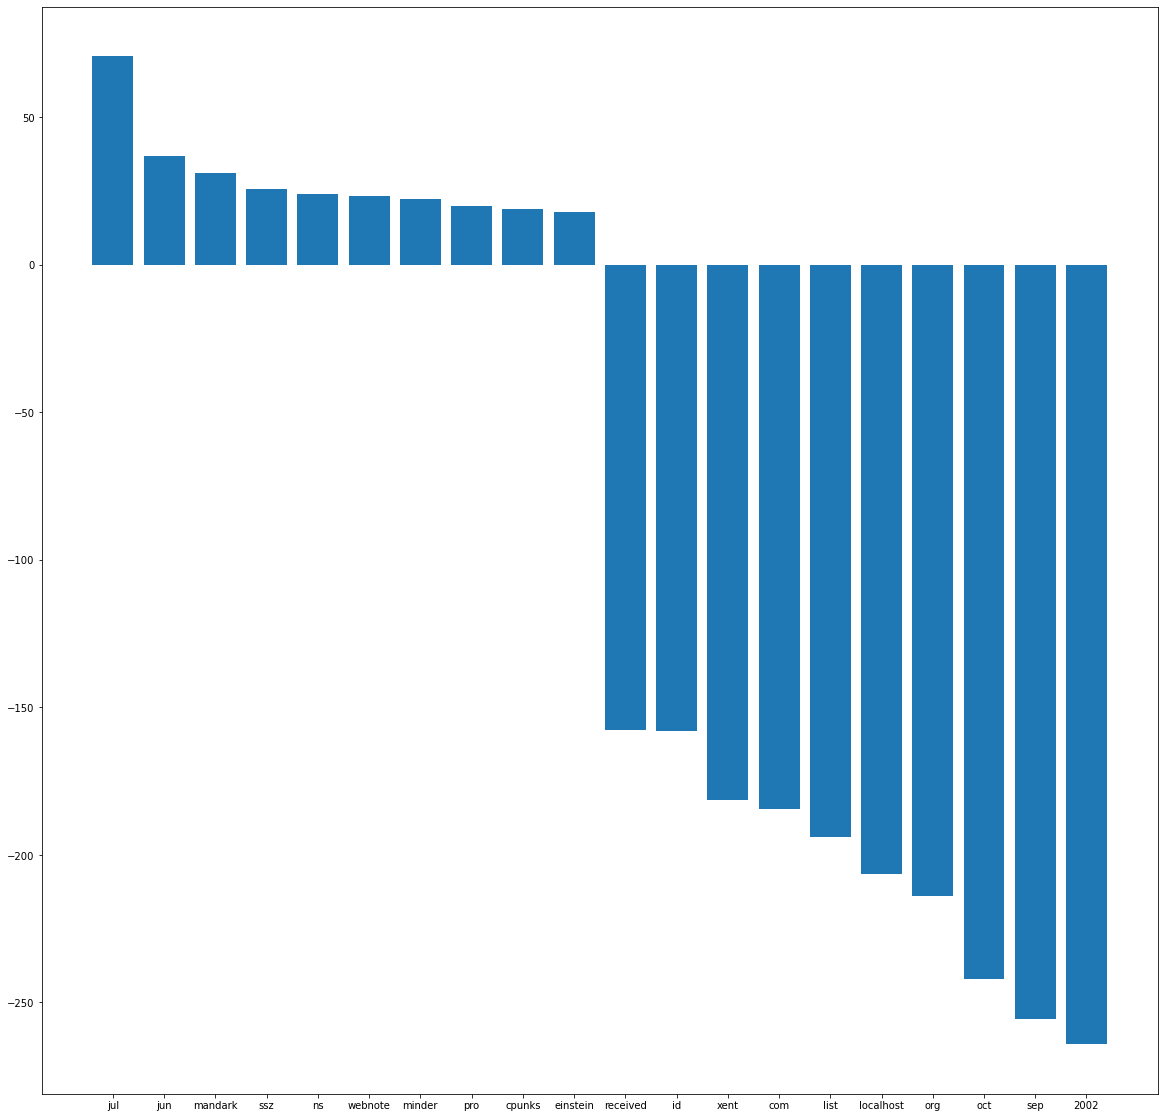

In [32]:
bag_of_words = preparation_pipeline.fit_transform(X_train)
count_vectorizer = preparation_pipeline.steps[1][1]
feature_names = count_vectorizer.get_feature_names_out()
spam_bag_of_words = bag_of_words[y_train.to_numpy() == 1, :]
ham_bag_of_words = bag_of_words[y_train.to_numpy() == 0, :]

differences = spam_bag_of_words.sum(axis=0) - ham_bag_of_words.sum(axis=0)

score_differences = sorted(zip(feature_names, np.asarray(differences).ravel().tolist()), key=lambda x: -x[1])

k = 10
head_names = [x[0] for x in score_differences[:k]]
head = [x[1] for x in score_differences[:k]]
tail_names = [x[0] for x in score_differences[-k:]]
tail = [x[1] for x in score_differences[-k:]]

fig, axs = plt.subplots(1, figsize=(20,20))
axs.bar(head_names+tail_names, head+tail)
plt.show()

In [37]:
X_train_prepared = preparation_pipeline.fit_transform(X_train)

In [13]:
X_train_prepared.shape

(5391, 114775)

In [14]:
len(y_train[y_train == 1.])

1416

### Shortlist promising models

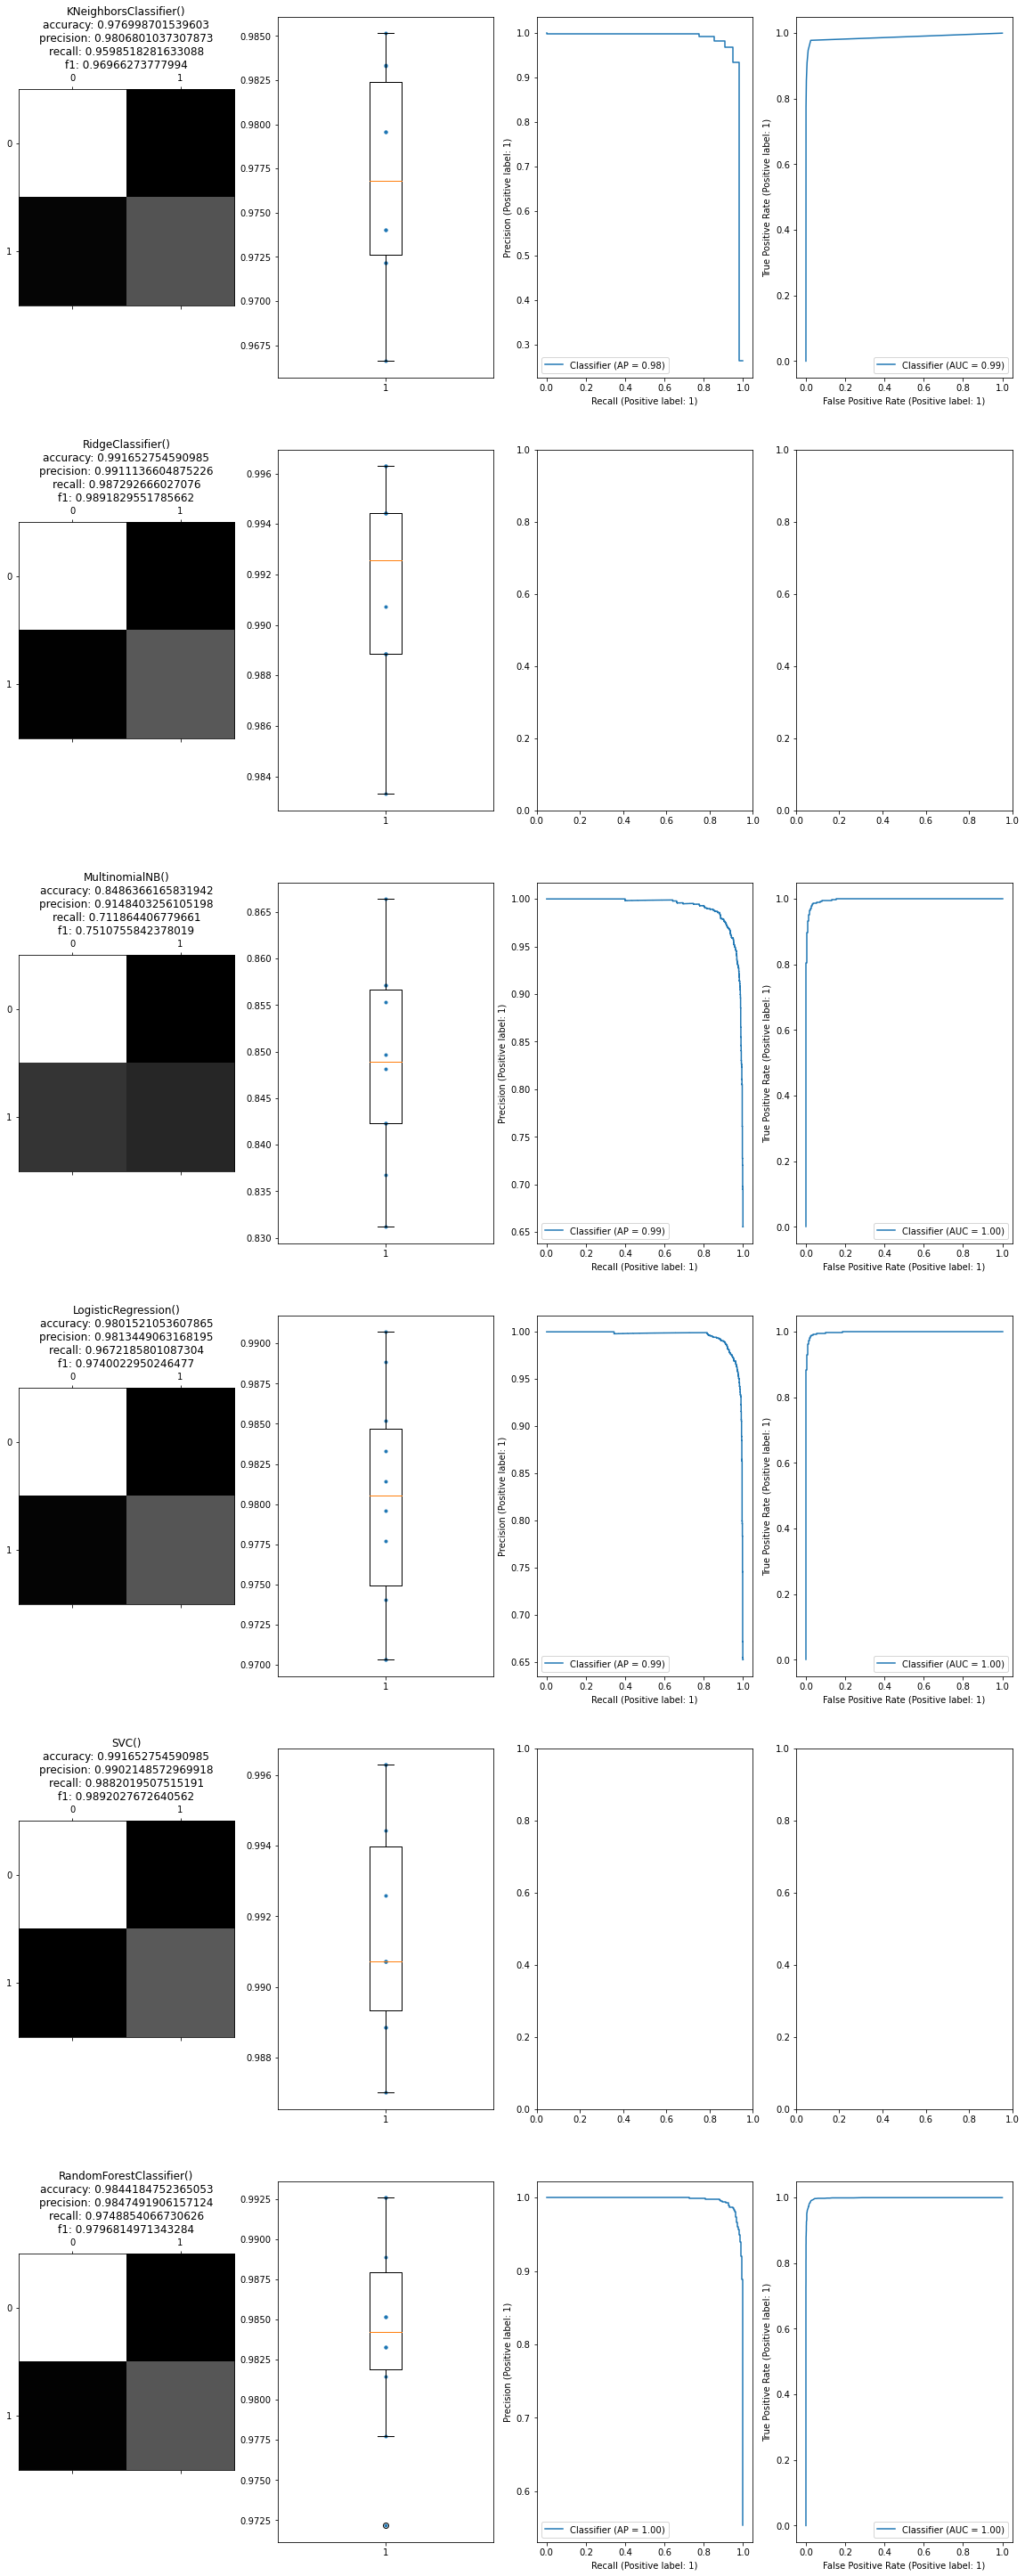

In [15]:
X_train_sample = X_train_prepared[:, :]
y_train_sample = y_train[:]

models = [
    KNeighborsClassifier(), 
    RidgeClassifier(),
    MultinomialNB(),
    LogisticRegression(),
    SVC(), 
    RandomForestClassifier(), 
]

k_folds = 10

fig, axs = plt.subplots(len(models), 4, figsize=(20, 35))
plt.subplots_adjust(top=1.25)
for i, model in enumerate(models):
    y_train_pred = cross_val_predict(model, X_train_sample, y_train_sample, cv=k_folds)
    scores = cross_val_score(model, X_train_sample, y_train_sample, cv=k_folds)
    conf_mx = confusion_matrix(y_train_sample, y_train_pred)
    accuracy = accuracy_score(y_train_sample, y_train_pred)
    precision = precision_score(y_train_sample, y_train_pred, average="macro")
    recall = recall_score(y_train_sample, y_train_pred, average="macro")
    f1 = f1_score(y_train_sample, y_train_pred, average="macro")
    axs[i, 0].matshow(conf_mx, cmap=plt.cm.gray)
    axs[i, 0].set_title(f"{model}\naccuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
   
    # cross validation scores boxplot
    axs[i, 1].plot([1]*k_folds, scores, ".")
    axs[i, 1].boxplot([scores])
    
    if hasattr(model, "predict_proba"):
        y_train_pred_proba = cross_val_predict(model, X_train_sample, y_train_sample, cv=3, method="predict_proba")
        PrecisionRecallDisplay.from_predictions(y_train_sample, y_train_pred_proba[:, 1], ax=axs[i, 2])
        RocCurveDisplay.from_predictions(y_train_sample, y_train_pred_proba[:, 1], ax=axs[i, 3])
    
plt.show()

### Optimize data cleaning parameters

In [20]:
ridge_classifier_pipeline = Pipeline([
    ("preparation", preparation_pipeline),
    ("ridge_clf", RidgeClassifier()),
])

param_grid = {
   # "preparation__clean__remove_headers": [False, True],
   # "preparation__clean__remove_html": [False, True],
   # "preparation__clean__replace_urls": [False, True],
   # "preparation__clean__lowercase": [False, True],
   # "preparation__vect__stem": [False, True],
    "preparation__vect__stop_words": [None, "english"],
    "preparation__vect__max_df": (0.7, 0.8, 1.0),
    "preparation__vect__max_features": (None, 5000, 10000, 50000),
    "preparation__vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "preparation__tfidf__use_idf": (True, False),
    "preparation__tfidf__norm": ("l1", "l2"),
}

grid_search = GridSearchCV(
    ridge_classifier_pipeline, 
    param_grid,
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  56.0s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time= 1.1min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=english; total time= 1.0min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time=  

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  53.2s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  55.3s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=english; total time=  43.1s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  35.7s
[CV] END preparation__tfidf__norm=l1, preparatio

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  55.4s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time= 1.1min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  53.7s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  55.8s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf_

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  55.6s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time= 1.1min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  52.8s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  49.8s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf_

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  56.6s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=english; total time= 1.1min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=english; total time=  59.7s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time= 1.0min
[CV] END preparation__tfidf__norm=l1, preparation__tfi

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  53.0s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  47.3s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=english; total time=  42.1s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  43.8s
[CV] END preparation__tfidf__norm=l1, preparation__tfi

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  55.3s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time= 1.1min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  50.1s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  43.9s
[CV] END preparation__tfidf__norm=l1, preparation__tfi

[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  55.1s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=None, preparation__vect__ngram_range=(1, 2), preparation__vect__stop_words=None; total time= 1.1min
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=None; total time=  53.2s
[CV] END preparation__tfidf__norm=l1, preparation__tfidf__use_idf=True, preparation__vect__max_df=0.7, preparation__vect__max_features=5000, preparation__vect__ngram_range=(1, 1), preparation__vect__stop_words=english; total time=  57.3s
[CV] END preparation__tfidf__norm=l1, preparation__tfi

	preparation__tfidf__norm: 'l2'
	preparation__tfidf__use_idf: True
	preparation__vect__max_df: 1.0
	preparation__vect__max_features: 50000
	preparation__vect__ngram_range: (1, 2)
	preparation__vect__stop_words: None


In [33]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.9946200099384266
Pipeline(steps=[('preparation',
                 Pipeline(steps=[('clean',
                                  RawEmailPreprocessor(lowercase=False,
                                                       remove_headers=False,
                                                       replace_urls=False)),
                                 ('vect',
                                  CountVectorizer(max_features=50000,
                                                  ngram_range=(1, 2))),
                                 ('tfidf', TfidfTransformer())])),
                ('ridge_clf', RidgeClassifier())])


### Optimize model parameters

In [38]:
param_distribs = [
    {
        "C": [1e-2, 1, 1e2],
        "gamma": [1e-1, 1, 1e1],
        "kernel": ["rbf"],
    },
    {
        "C": [.1 * 2**i for i in range(1, 10)],
        "degree": [2, 3, 4],
        "kernel": ["poly"],
    },
    {
        "C": [1e-2, 1, 1e2],
        "kernel": ["linear"],
    },
    {
        "C": [1e-2, 1, 1e2],
        "kernel": ["sigmoid"],
    },
]

svc = SVC()
rnd_search = RandomizedSearchCV(
    svc, 
    param_distributions=param_distribs,
    n_iter=10,
    cv=10,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
search = rnd_search.fit(X_train_prepared, y_train)
print(f"best estimator {search.best_estimator_}\nbest score {search.best_score_}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
best estimator SVC(C=100.0, gamma=0.1)
best score 0.996660482374768
[CV] END .......................C=6.4, degree=3, kernel=poly; total time= 2.3min
[CV] END .......................C=0.4, degree=3, kernel=poly; total time= 1.6min
[CV] END .......................C=0.4, degree=3, kernel=poly; total time= 1.6min
[CV] END ....................C=100.0, gamma=10.0, kernel=rbf; total time= 2.2min
[CV] END .......................C=6.4, degree=4, kernel=poly; total time= 2.3min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  51.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  53.6s
[CV] END .............................C=0.01, kernel=sigmoid; total time= 1.3min
[CV] END .......................C=1.6, degree=3, kernel=poly; total time= 2.4min
[CV] END ......................C=12.8, degree=4, kernel=poly; total time= 2.3min
[CV] END ......................C=25.6, degree=2, kernel=pol

In [66]:
def plot_learning_curves(model, X, y, ax=plt):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_scores, val_scores = [], []
    for m in range(5, X_train.shape[0] + 1, X_train.shape[0] // 50):
        print(f"model: {model}, m: {m}")
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_scores.append(f1_score(y_train[:m], y_train_predict, average="macro"))
        val_scores.append(f1_score(y_val, y_val_predict, average="macro"))

    ax.plot(np.sqrt(train_scores), "r-+", linewidth=2, label="train")
    ax.plot(np.sqrt(val_scores), "b-", linewidth=3, label="val")
    ax.legend(loc="upper right", fontsize=14)   # not shown in the book
    ax.set_title(str(model))
    ax.set(xlabel="Training set epoch", ylabel="f1 macro score")

model: KNeighborsClassifier(), m: 5
model: KNeighborsClassifier(), m: 37
model: KNeighborsClassifier(), m: 69
model: KNeighborsClassifier(), m: 101
model: KNeighborsClassifier(), m: 133
model: KNeighborsClassifier(), m: 165
model: KNeighborsClassifier(), m: 197
model: KNeighborsClassifier(), m: 229
model: KNeighborsClassifier(), m: 261
model: KNeighborsClassifier(), m: 293
model: KNeighborsClassifier(), m: 325
model: KNeighborsClassifier(), m: 357
model: KNeighborsClassifier(), m: 389
model: KNeighborsClassifier(), m: 421
model: KNeighborsClassifier(), m: 453
model: KNeighborsClassifier(), m: 485
model: KNeighborsClassifier(), m: 517
model: KNeighborsClassifier(), m: 549
model: KNeighborsClassifier(), m: 581
model: KNeighborsClassifier(), m: 613
model: KNeighborsClassifier(), m: 645
model: KNeighborsClassifier(), m: 677
model: KNeighborsClassifier(), m: 709
model: KNeighborsClassifier(), m: 741
model: KNeighborsClassifier(), m: 773
model: KNeighborsClassifier(), m: 805
model: KNeighbor

model: RandomForestClassifier(), m: 165
model: RandomForestClassifier(), m: 197
model: RandomForestClassifier(), m: 229
model: RandomForestClassifier(), m: 261
model: RandomForestClassifier(), m: 293
model: RandomForestClassifier(), m: 325
model: RandomForestClassifier(), m: 357
model: RandomForestClassifier(), m: 389
model: RandomForestClassifier(), m: 421
model: RandomForestClassifier(), m: 453
model: RandomForestClassifier(), m: 485
model: RandomForestClassifier(), m: 517
model: RandomForestClassifier(), m: 549
model: RandomForestClassifier(), m: 581
model: RandomForestClassifier(), m: 613
model: RandomForestClassifier(), m: 645
model: RandomForestClassifier(), m: 677
model: RandomForestClassifier(), m: 709
model: RandomForestClassifier(), m: 741
model: RandomForestClassifier(), m: 773
model: RandomForestClassifier(), m: 805
model: RandomForestClassifier(), m: 837
model: RandomForestClassifier(), m: 869
model: RandomForestClassifier(), m: 901
model: RandomForestClassifier(), m: 933


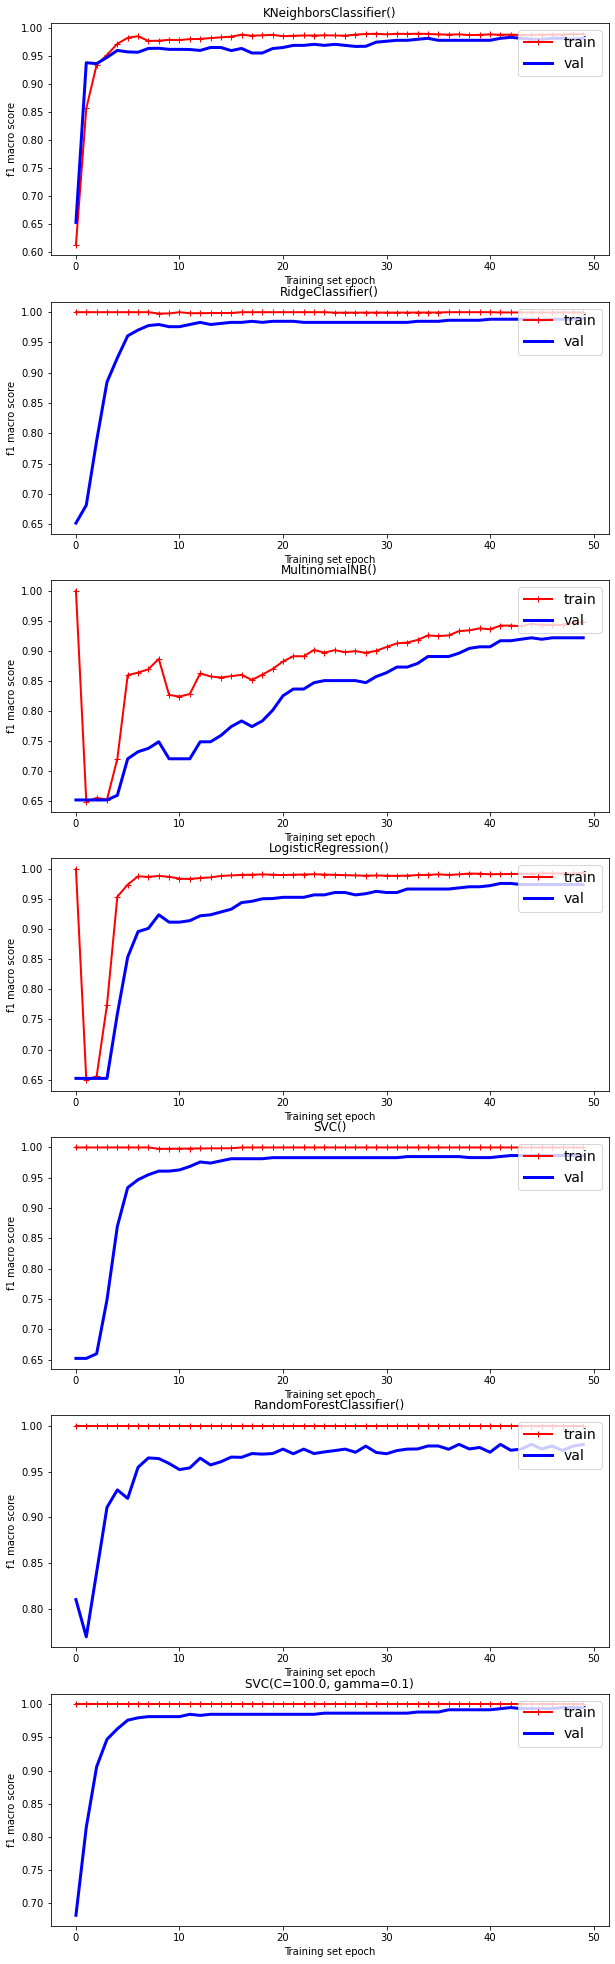

In [67]:
fig, axs = plt.subplots(len(models)+1, 1, figsize=(10, 35))
for i, model in enumerate(models + [search.best_estimator_]):
    plot_learning_curves(model, X_train_prepared[:2000], y_train[:2000], ax=axs[i])
# plt.axis([0, 80, 0, 3])
plt.show()

### Evaluate test set

accuracy: 0.9955506117908788
precision: 0.9949259805178159
recall: 0.9935721681110514
f1: 0.9942465564936633


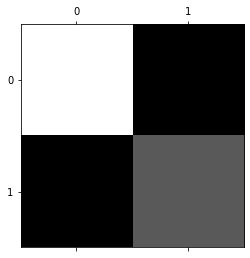

In [71]:
X_test_prepared = preparation_pipeline.transform(X_test)

search.best_estimator_.fit(X_train_prepared, y_train)
y_test_pred = search.best_estimator_.predict(X_test_prepared)
conf_mx = confusion_matrix(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average="macro")
recall = recall_score(y_test, y_test_pred, average="macro")
f1 = f1_score(y_test, y_test_pred, average="macro")
plt.matshow(conf_mx, cmap=plt.cm.gray)
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")